Shape of the dataset: (17898, 9)

First five rows:
      Mean_IP      SD_IP  ExcessKurtosis_IP  Skewness_IP  Mean_DM_SNR  \
0  140.562500  55.683782          -0.234571    -0.699648     3.199833   
1  102.507812  58.882430           0.465318    -0.515088     1.677258   
2  103.015625  39.341649           0.323328     1.051164     3.121237   
3  136.750000  57.178449          -0.068415    -0.636238     3.642977   
4   88.726562  40.672225           0.600866     1.123492     1.178930   

   SD_DM_SNR  ExcessKurtosis_DM_SNR  Skewness_DM_SNR  Class  
0  19.110426               7.975532        74.242225      0  
1  14.860146              10.576487       127.393580      0  
2  21.744669               7.735822        63.171909      0  
3  20.959280               6.896499        53.593661      0  
4  11.468720              14.269573       252.567306      0  

Missing values per column:
Mean_IP                  0
SD_IP                    0
ExcessKurtosis_IP        0
Skewness_IP              0
Me

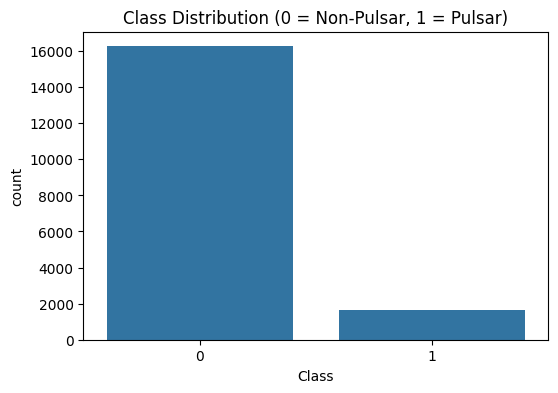

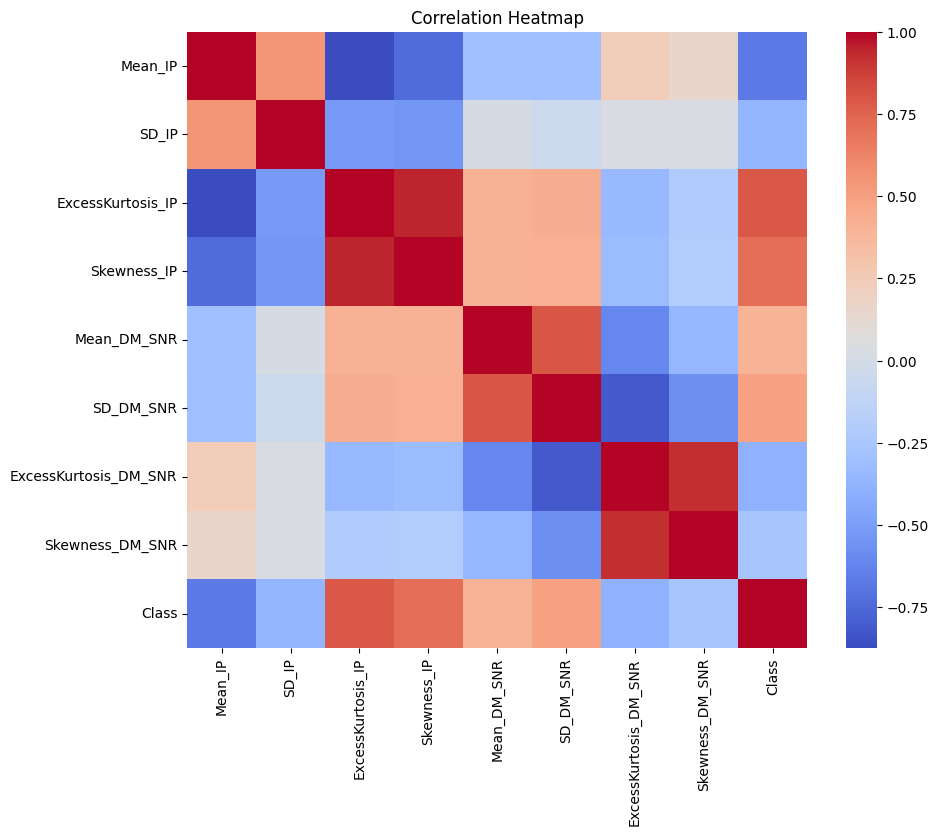

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# loading the dataset
data = pd.read_csv("/content/HTRU_2.csv", header=None)

# assigning column names as described in the dataset documentation
data.columns = [ "Mean_IP", "SD_IP", "ExcessKurtosis_IP", "Skewness_IP", "Mean_DM_SNR", "SD_DM_SNR", "ExcessKurtosis_DM_SNR",  "Skewness_DM_SNR", "Class"
]

# checking dataset shape
print("Shape of the dataset:", data.shape)
# previewing the first few rows
print("\nFirst five rows:")
print(data.head())

# checking for missing values in each column
print("\nMissing values per column:")
print(data.isnull().sum())

# basic statistics for each numerical column
print("\nSummary statistics:")
print(data.describe())

# checking how many pulsars vs non-pulsars
print("\nClass distribution:")
print(data['Class'].value_counts())
# quick visualization of class imbalance
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title("Class Distribution (0 = Non-Pulsar, 1 = Pulsar)")
plt.show()
# correlation heatmap to see relationships between features
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
# separating features and target
X = data.drop("Class", axis=1).values
y = data["Class"].values

# creating train, validation, test splits with stratification to respect class imbalance
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("Train shape:", X_train.shape, " Pulsar ratio:", y_train.mean())
print("Validation shape:", X_val.shape, " Pulsar ratio:", y_val.mean())
print("Test shape:", X_test.shape, " Pulsar ratio:", y_test.mean())
# scaling features so they are on a similar range for the neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# computing class weights to handle the imbalance during training
classes = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weights = dict(zip(classes, class_weights_array))

print("\nClass weights (for use in model training):")
print(class_weights)


Train shape: (12528, 8)  Pulsar ratio: 0.09155491698595147
Validation shape: (2685, 8)  Pulsar ratio: 0.09162011173184358
Test shape: (2685, 8)  Pulsar ratio: 0.09162011173184358

Class weights (for use in model training):
{np.int64(0): np.float64(0.5503910025481065), np.int64(1): np.float64(5.461203138622493)}


## MLP Model

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# creating the model
model = models.Sequential()
model.add(layers.Input(shape=(8,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
# setting early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# training the model
history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8362 - auc: 0.8920 - loss: 0.3980 - precision: 0.3631 - recall: 0.8274 - val_accuracy: 0.9665 - val_auc: 0.9666 - val_loss: 0.1294 - val_precision: 0.7786 - val_recall: 0.8862
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9444 - auc: 0.9654 - loss: 0.2335 - precision: 0.6589 - recall: 0.8904 - val_accuracy: 0.9691 - val_auc: 0.9712 - val_loss: 0.1329 - val_precision: 0.7964 - val_recall: 0.8902
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9620 - auc: 0.9679 - loss: 0.1937 - precision: 0.7334 - recall: 0.9075 - val_accuracy: 0.9683 - val_auc: 0.9744 - val_loss: 0.1372 - val_precision: 0.7885 - val_recall: 0.8943
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9616 - auc: 0.9657 - loss: 0.2042 - precision: 0.7410 - recall: 0.8990 - val_accuracy: 0.9650 - val_auc: 0.9748 - val_loss: 0.1393 - val_precision: 0.7603 - val_recall: 0.9024
Epoch 5/100
392/392 ━━━━━━

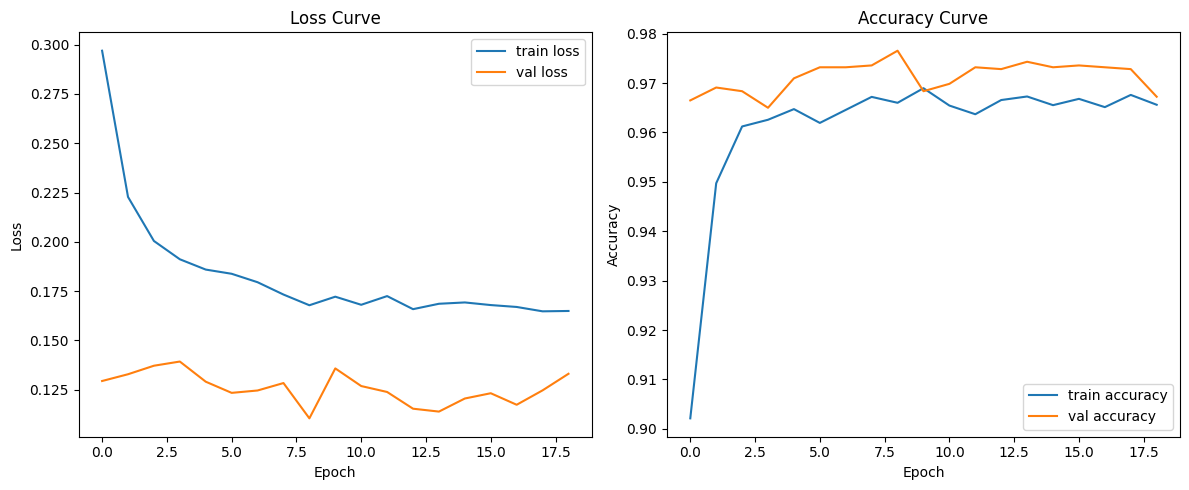

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9913    0.9820    0.9866      2439
           1     0.8364    0.9146    0.8738       246

    accuracy                         0.9758      2685
   macro avg     0.9139    0.9483    0.9302      2685
weighted avg     0.9771    0.9758    0.9763      2685



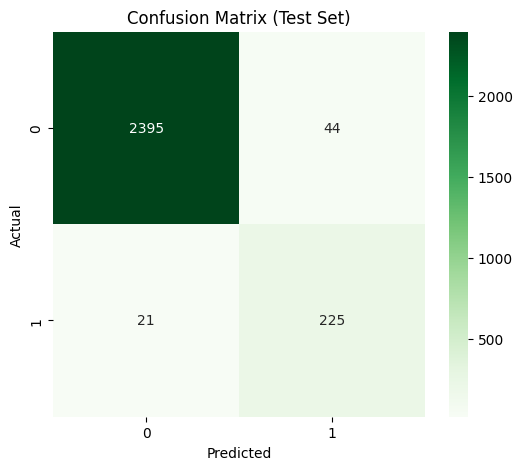

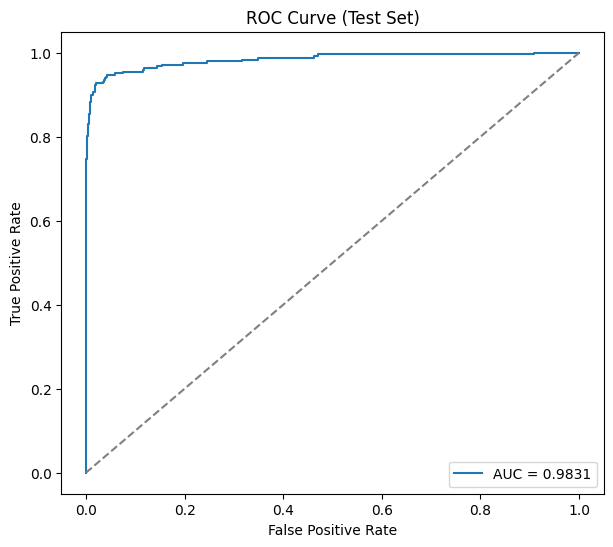


AUC (Test Set): 0.9831


In [13]:
# test set predictions
test_pred_probs = model.predict(X_test_scaled)
test_preds = (test_pred_probs > 0.5).astype(int)

# classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_preds, digits=4))

# confusion matrix
cm_test = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve & AUC
fpr_test, tpr_test, _ = roc_curve(y_test, test_pred_probs)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,6))
plt.plot(fpr_test, tpr_test, label=f"AUC = {roc_auc_test:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("ROC Curve (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nAUC (Test Set): {roc_auc_test:.4f}")


## LSTM-based ANN

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# reshaping the scaled data to fit LSTM input format
# LSTM expects (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 8, 1)
X_val_lstm = X_val_scaled.reshape(X_val_scaled.shape[0], 8, 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 8, 1)
# LSTM model
lstm_model = models.Sequential()
lstm_model.add(layers.LSTM(32, input_shape=(8, 1)))
lstm_model.add(layers.Dropout(0.3))
lstm_model.add(layers.Dense(16, activation='relu'))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(1, activation='sigmoid'))
# compiling
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
# early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# training
lstm_history = lstm_model.fit(
    X_train_lstm,
    y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8436 - auc: 0.8559 - loss: 0.4816 - precision: 0.3681 - recall: 0.7554 - val_accuracy: 0.9404 - val_auc: 0.9585 - val_loss: 0.1905 - val_precision: 0.6201 - val_recall: 0.9024
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9497 - auc: 0.9648 - loss: 0.2095 - precision: 0.6589 - recall: 0.9000 - val_accuracy: 0.9534 - val_auc: 0.9598 - val_loss: 0.1995 - val_precision: 0.6873 - val_recall: 0.9024
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9553 - auc: 0.9607 - loss: 0.2138 - precision: 0.6955 - recall: 0.8937 - val_accuracy: 0.9531 - val_auc: 0.9627 - val_loss: 0.1686 - val_precision: 0.6852 - val_recall: 0.9024
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9568 - auc: 0.9689 - loss: 0.2007 - precision: 0.7066 - recall: 0.8977 - val_accuracy: 0.9493 - val_auc: 0.9648 - val_loss: 0.1786 - val_precision: 0.6637 - val_recall: 0.9065
Epoch 5/100
392/392 ━━━━━━━

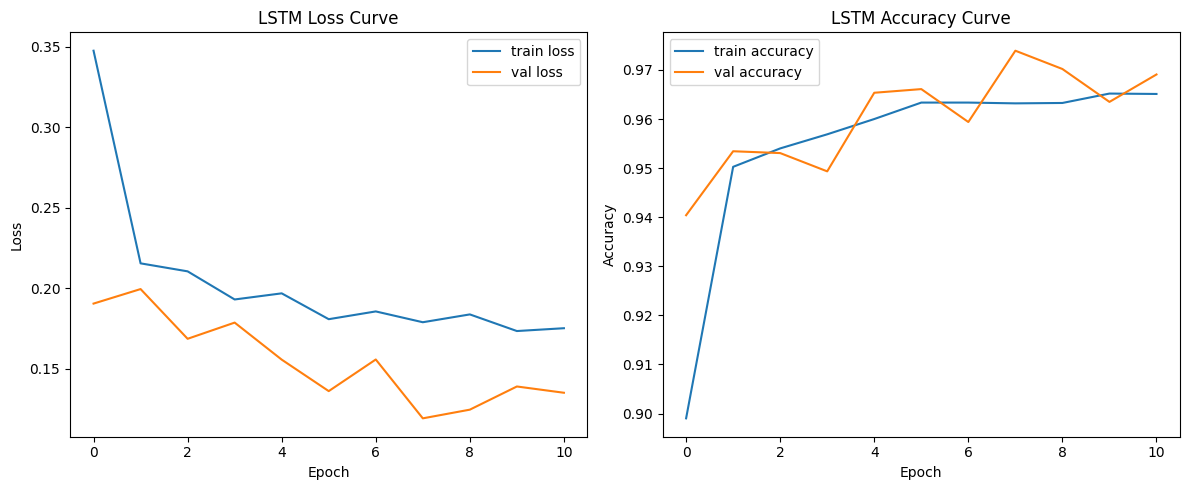

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# training curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(lstm_history.history['loss'], label='train loss')
plt.plot(lstm_history.history['val_loss'], label='val loss')
plt.title("LSTM Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(lstm_history.history['accuracy'], label='train accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='val accuracy')
plt.title("LSTM Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report (LSTM - Test Set):
              precision    recall  f1-score   support

           0     0.9901    0.9840    0.9870      2439
           1     0.8506    0.9024    0.8757       246

    accuracy                         0.9765      2685
   macro avg     0.9203    0.9432    0.9314      2685
weighted avg     0.9773    0.9765    0.9768      2685



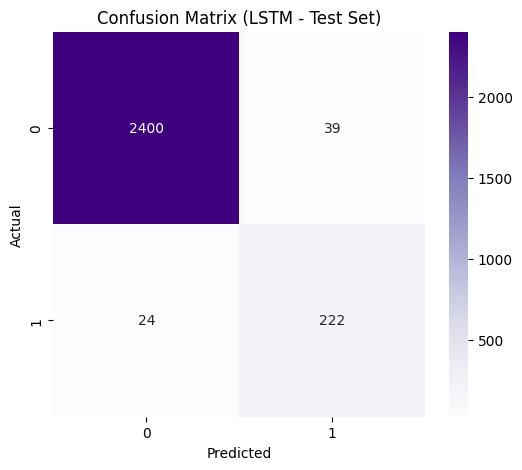

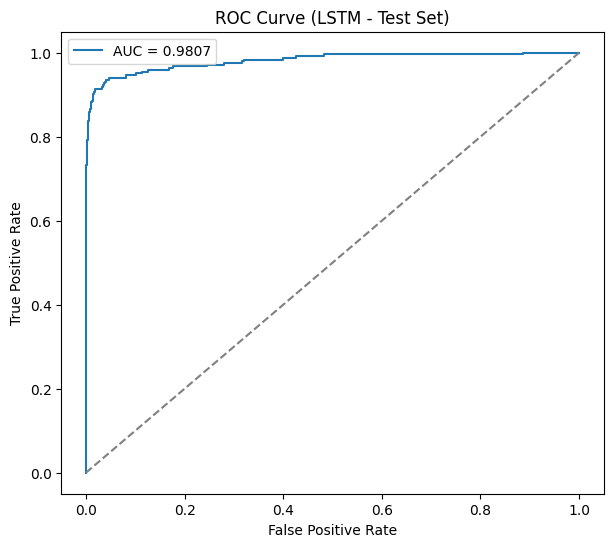


AUC (LSTM - Test Set): 0.9807


In [18]:
# predictions
test_probs = lstm_model.predict(X_test_lstm)
test_preds = (test_probs > 0.5).astype(int)

# classification report
print("\nClassification Report (LSTM - Test Set):")
print(classification_report(y_test, test_preds, digits=4))

# confusion matrix
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix (LSTM - Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve + AUC
fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("ROC Curve (LSTM - Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nAUC (LSTM - Test Set): {roc_auc:.4f}")
